In [1]:
!pip install torchinfo==1.7.0

### 1. Importing Libraries

In [2]:
import torch
print('PyTorch version:', torch.__version__)
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision
print('Torchvision version:', torchvision.__version__)
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from tqdm import tqdm
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124


### 2. Devine the device


In [3]:
print("GUP name:", torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cup'
print('Deice is:', device, '\n')
print('Total number of GPUs:', torch.cuda.device_count())

GUP name: NVIDIA A100-SXM4-40GB 

Deice is: cuda 

Total number of GPUs: 1


###3. Load MNIST dataset

In [4]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=(0.5,), std = (0.5,))])

# torchvision.datasets.CelebA(root, split = 'train', target_type = 'attr', transform = None, target_transform = None, download = False)

training_dataset = datasets.MNIST(root='./data_src', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data_src', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 41.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.21MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.11MB/s]


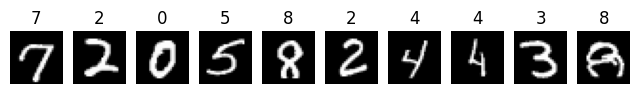

In [5]:
# show 10 randomly selected samples from the training dataset

fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(8, 1))

for ax, _ in zip(axis.ravel(), range(10)):
  inx = np.random.randint(len(training_dataset))
  ax.imshow(training_dataset.data[inx], cmap='gray')
  ax.set_title(int(training_dataset.targets[inx]), fontsize = 12)
  ax.axis(False);

4. Define dataloaders

In [6]:
training_dataloader = DataLoader(training_dataset, batch_size=64, shuffle=True, drop_last = True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

### 5. Define Linear Variance Scheduler

In [7]:
import scipy.stats
import math


class Linear_Variance_Scheduler:
    def __init__(self, time_steps, beta_start, beta_end, device='cuda'):

        self.time_steps = time_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device

        self.betas = torch.linspace(self.beta_start, self.beta_end, self.time_steps).to(self.device)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)

    def diffusion_process(self, x, noise, t):
        sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None, None]
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None, None]
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise

    def ddpm_sampling(self, model, num_samples, channels, img_size):
        model.eval()
        with torch.inference_mode():
            x = torch.randn((num_samples, channels, img_size, img_size)).to(self.device)
            collect = []
            for i in tqdm(reversed(range(self.time_steps))):
                t = (torch.ones(num_samples) * i).long().to(self.device)
                pred_noise = model(x, t)
                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alphas) * (x - ((1 - alphas) / (torch.sqrt(1 - alpha_bar))) * pred_noise) +\
                    torch.sqrt(betas) * noise
                if (i+1) % 100 == 0 or i==0:
                    collect.append(x)
        return x, collect

    def ddpm_sampling_student_t(self, model, num_samples, channels, img_size):
        model.eval()
        with torch.inference_mode():
            # Sample from Student's t-distribution with df=3
            dist = torch.distributions.StudentT(df=3)
            x = dist.rsample((num_samples, channels, img_size, img_size)).to(self.device)
            collect = []
            for i in tqdm(reversed(range(self.time_steps))):
                t = (torch.ones(num_samples) * i).long().to(self.device)
                pred_noise = model(x, t)
                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x) # You might want to change this to Student's t as well
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alphas) * (x - ((1 - alphas) / (torch.sqrt(1 - alpha_bar))) * pred_noise) +\
                    torch.sqrt(betas) * noise
                if (i+1) % 100 == 0 or i==0:
                    collect.append(x)
        return x, collect

    def ddpm_sampling_gamma_distribution(self, model, num_samples, channels, img_size):
        model.eval()
        with torch.inference_mode():
            dist = torch.distributions.Gamma(concentration=1.0, rate=1.0)  # Adjust parameters as needed
            x = dist.rsample((num_samples, channels, img_size, img_size)).to(self.device)
            raw = dist.rsample((num_samples, channels, img_size, img_size)).to(self.device)

            # dist.mean is k/θ; dist.variance is k/θ²
            shifted = raw - dist.mean    # now E[shifted]=0
            # std = torch.sqrt(dist.variance.to(self.device))
            x = shifted #/ std

            collect = []
            for i in tqdm(reversed(range(self.time_steps))):
                t = (torch.ones(num_samples) * i).long().to(self.device)
                pred_noise = model(x, t)
                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x) # You might want to change this to Student's t as well
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alphas) * (x - ((1 - alphas) / (torch.sqrt(1 - alpha_bar))) * pred_noise) +\
                    torch.sqrt(betas) * noise
                if (i+1) % 100 == 0 or i==0:
                    collect.append(x)
        return x, collect


    def ddpm_sampling_frechet(self, model, num_samples, channels, img_size):
        model.eval()
        with torch.inference_mode():
            # 1) Fréchet parameters
            loc   = 0.0      # m
            scale = 1.0      # s
            shape = 3.0      # α  (must be >1 for mean to exist)

            # 2) sample U~Uniform(0,1)
            u = torch.rand((num_samples, channels, img_size, img_size),
                          device=self.device)

            # 3) invert to Fréchet
            x_raw = loc + scale * torch.pow(-torch.log(u), -1.0/shape)

            # 4) compute the mean: E[X] = loc + scale * Γ(1 - 1/α)
            mean_offset = loc + scale * math.gamma(1.0 - 1.0/shape)

            # 5) subtract mean to center at zero
            x = x_raw - mean_offset

            collect = []
            for i in tqdm(reversed(range(self.time_steps))):
                t = torch.full((num_samples,), i, device=self.device, dtype=torch.long)
                pred_noise = model(x, t)

                α     = self.alphas[t][:, None, None, None]
                α_bar = self.alpha_bar[t][:, None, None, None]
                β     = self.betas[t][:, None, None, None]

                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)

                x = (1/torch.sqrt(α)) * (x - ((1-α)/torch.sqrt(1-α_bar)) * pred_noise) \
                    + torch.sqrt(β) * noise

                if (i + 1) % 100 == 0 or i == 0:
                    collect.append(x.clone())

        return x, collect


### 6. Forward Process Output

In [8]:
t_step = torch.linspace(start=0, end=1000-1, steps=11).long()
get_img = training_dataset[0][0]
print('Image label:', training_dataset[0][1])
get_img_stack = torch.stack([get_img]*11)
get_noise_stack = torch.randn_like(get_img_stack)

noisy_img_stack = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02,
                                            device='cpu').diffusion_process(get_img_stack, get_noise_stack, t_step)

Image label: 5


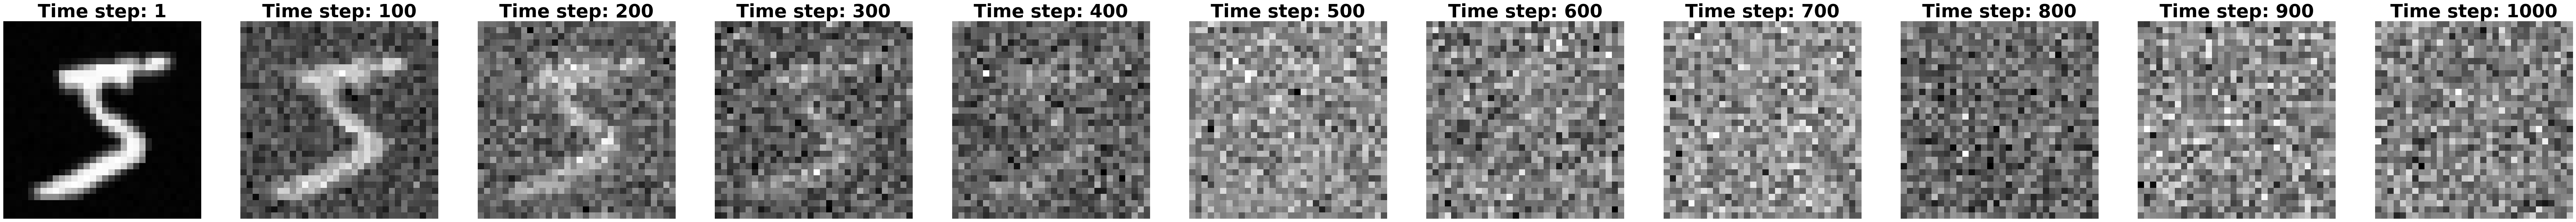

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=11, figsize=(100, 100))

for idx, img in enumerate(noisy_img_stack):
    ax[idx].imshow(img.squeeze(), cmap='gray')
    ax[idx].set_title(f'Time step: {t_step[idx]+1}', fontsize=40, fontweight='bold')
    ax[idx].axis(False);

### 7. Create ResBlock

In [10]:
class ResBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, mid_ch=None, residual=False):
        super(ResBlock, self).__init__()

        self.residual = residual
        if not mid_ch:
            mid_ch = out_ch
        self.resnet_conv = nn.Sequential()
        self.resnet_conv.add_module('conv1', nn.Conv2d(in_channels=inp_ch, out_channels=mid_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor1', nn.GroupNorm(num_groups=8, num_channels=mid_ch))
        self.resnet_conv.add_module('silu1', nn.SiLU())
        self.resnet_conv.add_module('conv2', nn.Conv2d(in_channels=mid_ch, out_channels=out_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor2', nn.GroupNorm(num_groups=8, num_channels=out_ch))

    def forward(self, x):
        if self.residual:
            return x + self.resnet_conv(x)
        else:
            return self.resnet_conv(x)

### 8. SelfAttentionBlock

In [11]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, channels):
        super(SelfAttentionBlock, self).__init__()

        self.attn_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mha = nn.MultiheadAttention(embed_dim=channels, num_heads=4, batch_first=True)

    def forward(self, x):
        b, c, h, w = x.shape
        inp_attn = x.reshape(b, c, h*w)
        inp_attn = self.attn_norm(inp_attn)
        inp_attn = inp_attn.transpose(1, 2)
        out_attn, _ = self.mha(inp_attn, inp_attn, inp_attn)
        out_attn = out_attn.transpose(1, 2).reshape(b, c, h, w)
        return x + out_attn

### 9. Create DownBlock

In [12]:
class DownBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(DownBlock, self).__init__()

        self.down = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch)
        )

        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))

    def forward(self, x, t):
        x = self.down(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

### 10. Create UpBlock

In [13]:
class UpBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(UpBlock, self).__init__()

        self.upsamp = nn.UpsamplingBilinear2d(scale_factor=2)
        self.up = nn.Sequential(
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch, mid_ch=inp_ch//2)
        )

        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))

    def forward(self, x, skip, t):
        x = self.upsamp(x)
        x = torch.cat([skip, x], dim=1)
        x = self.up(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

### 11. Create UNet Architecture

In [14]:
class UNet(nn.Module):
    def __init__(self, t_emb_dim, device='cuda'):
        super(UNet, self).__init__()

        self.device = device
        self.t_emb_dim = t_emb_dim

        self.inp = ResBlock(inp_ch=1, out_ch=64)
        self.down1 = DownBlock(inp_ch=64, out_ch=128)
        self.sa1 = SelfAttentionBlock(channels=128)
        self.down2 = DownBlock(inp_ch=128, out_ch=256)
        self.sa2 = SelfAttentionBlock(channels=256)
        self.down3 = DownBlock(inp_ch=256, out_ch=256)
        self.sa3 = SelfAttentionBlock(channels=256)

        self.lat1 = ResBlock(inp_ch=256, out_ch=512)
        self.lat2 = ResBlock(inp_ch=512, out_ch=512)
        self.lat3 = ResBlock(inp_ch=512, out_ch=256)

        self.up1 = UpBlock(inp_ch=512, out_ch=128)
        self.sa4 = SelfAttentionBlock(channels=128)
        self.up2 = UpBlock(inp_ch=256, out_ch=64)
        self.sa5 = SelfAttentionBlock(channels=64)
        self.up3 = UpBlock(inp_ch=128, out_ch=64)
        self.sa6 = SelfAttentionBlock(channels=64)

        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

    def position_embeddings(self, t, channels):
        i = 1 / (10000 ** (torch.arange(start=0, end=channels, step=2, device=self.device) / channels))
        pos_emb_sin = torch.sin(t.repeat(1, channels//2) * i)
        pos_emb_cos = torch.cos(t.repeat(1, channels//2) * i)
        pos_emb = torch.cat([pos_emb_sin, pos_emb_cos], dim=-1)
        return pos_emb

    def forward(self, x, t):
        t = t.unsqueeze(1).float()
        t = self.position_embeddings(t, self.t_emb_dim)

        x1 = self.inp(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.lat1(x4)
        x4 = self.lat2(x4)
        x4 = self.lat3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.out(x)
        return output

### 12. visualize `UNet` Architecture

In [15]:
summary(UNet(t_emb_dim=256), input_size=[(64, 1, 32, 32), (64,)])

/usr/local/lib/python3.11/dist-packages/torchinfo/torchinfo.py:452: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type:depth-idx)                                  Output Shape              Param #
UNet                                                    [64, 1, 32, 32]           --
├─ResBlock: 1-1                                         [64, 64, 32, 32]          --
│    └─Sequential: 2-1                                  [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-1                                 [64, 64, 32, 32]          640
│    │    └─GroupNorm: 3-2                              [64, 64, 32, 32]          128
│    │    └─SiLU: 3-3                                   [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-4                                 [64, 64, 32, 32]          36,928
│    │    └─GroupNorm: 3-5                              [64, 64, 32, 32]          128
├─DownBlock: 1-2                                        [64, 128, 16, 16]         --
│    └─Sequential: 2-2                                  [64, 128, 16, 16]         --
│    │    └─MaxPool2d: 3-6                           

### 13. Linear variance scheudler model unet criterion loss function and optimizer

In [16]:
ddpm = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02)
model = UNet(t_emb_dim=256).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### 14. Train UNet

In [ ]:
torch.manual_seed(1111)
torch.cuda.manual_seed(1111)
torch.cuda.manual_seed_all(1111)
np.random.seed(1111)

n_epochs = 25
training_loss, test_loss = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []

    for data, _ in tqdm(training_dataloader):
        model.train()
        data = data.to(device)
        t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
        noise = torch.randn_like(data)
        xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
        pred_noise = model(xt, t)
        trng_batch_loss = criterion(noise, pred_noise)
        optimizer.zero_grad()
        trng_batch_loss.backward()
        optimizer.step()
        training_losses.append(trng_batch_loss.item())
    training_per_epoch_loss = np.array(training_losses).mean()

    with torch.inference_mode():
        for data, _ in tqdm(test_dataloader):
            model.eval()
            data = data.to(device)
            t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
            noise = torch.randn_like(data)
            xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
            pred_noise = model(xt, t)
            tst_batch_loss = criterion(noise, pred_noise)
            test_losses.append(tst_batch_loss.item())
        test_per_epoch_loss = np.array(test_losses).mean()

    training_loss.append(training_per_epoch_loss)
    test_loss.append(test_per_epoch_loss)

    print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} |   ', end='')
    print(f'Test loss: {test_per_epoch_loss:.4f}')

100%|██████████| 156/156 [00:06<00:00, 25.55it/s]


Epoch: 1/25	| Training loss: 0.0632 |   Test loss: 0.0310


100%|██████████| 156/156 [00:06<00:00, 25.35it/s]


Epoch: 2/25	| Training loss: 0.0282 |   Test loss: 0.0267


100%|██████████| 156/156 [00:06<00:00, 25.43it/s]


Epoch: 3/25	| Training loss: 0.0243 |   Test loss: 0.0226


100%|██████████| 156/156 [00:06<00:00, 25.58it/s]


Epoch: 4/25	| Training loss: 0.0220 |   Test loss: 0.0202


100%|██████████| 156/156 [00:06<00:00, 25.31it/s]


Epoch: 5/25	| Training loss: 0.0205 |   Test loss: 0.0204


100%|██████████| 156/156 [00:06<00:00, 25.28it/s]


Epoch: 6/25	| Training loss: 0.0195 |   Test loss: 0.0195


100%|██████████| 156/156 [00:06<00:00, 25.26it/s]


Epoch: 7/25	| Training loss: 0.0190 |   Test loss: 0.0185


100%|██████████| 156/156 [00:06<00:00, 25.31it/s]


Epoch: 8/25	| Training loss: 0.0184 |   Test loss: 0.0180


100%|██████████| 156/156 [00:06<00:00, 25.27it/s]


Epoch: 9/25	| Training loss: 0.0180 |   Test loss: 0.0178


100%|██████████| 156/156 [00:06<00:00, 25.42it/s]


Epoch: 10/25	| Training loss: 0.0175 |   Test loss: 0.0175


100%|██████████| 156/156 [00:06<00:00, 25.23it/s]


Epoch: 11/25	| Training loss: 0.0176 |   Test loss: 0.0175


100%|██████████| 156/156 [00:06<00:00, 25.46it/s]


Epoch: 12/25	| Training loss: 0.0173 |   Test loss: 0.0169


100%|██████████| 156/156 [00:06<00:00, 25.70it/s]


Epoch: 13/25	| Training loss: 0.0169 |   Test loss: 0.0166


100%|██████████| 156/156 [00:06<00:00, 25.63it/s]


Epoch: 14/25	| Training loss: 0.0167 |   Test loss: 0.0162


100%|██████████| 156/156 [00:06<00:00, 25.40it/s]


Epoch: 15/25	| Training loss: 0.0168 |   Test loss: 0.0165


100%|██████████| 156/156 [00:06<00:00, 25.54it/s]


Epoch: 16/25	| Training loss: 0.0164 |   Test loss: 0.0164


100%|██████████| 156/156 [00:06<00:00, 25.36it/s]


Epoch: 17/25	| Training loss: 0.0162 |   Test loss: 0.0163


100%|██████████| 156/156 [00:06<00:00, 25.42it/s]


Epoch: 18/25	| Training loss: 0.0162 |   Test loss: 0.0161


100%|██████████| 156/156 [00:06<00:00, 25.51it/s]


Epoch: 19/25	| Training loss: 0.0163 |   Test loss: 0.0158


100%|██████████| 156/156 [00:06<00:00, 25.39it/s]


Epoch: 20/25	| Training loss: 0.0159 |   Test loss: 0.0156


100%|██████████| 156/156 [00:06<00:00, 25.16it/s]


Epoch: 21/25	| Training loss: 0.0159 |   Test loss: 0.0161


100%|██████████| 156/156 [00:06<00:00, 25.65it/s]


Epoch: 22/25	| Training loss: 0.0160 |   Test loss: 0.0158


 59%|█████▉    | 552/937 [00:43<00:30, 12.64it/s]

In [ ]:
torch.save(model.state_dict(), 'unconditional_ddpm_digits.pth')

### Plot Losses

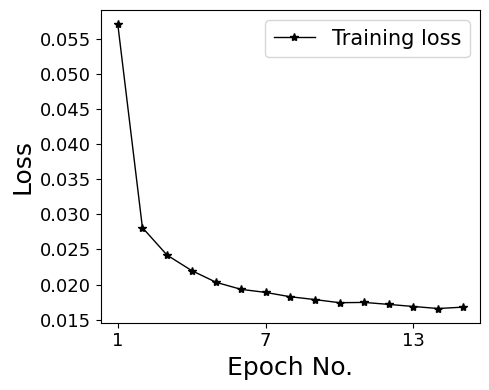

In [ ]:
N = np.arange(n_epochs) + 1

plt.figure(figsize=(5, 4))
plt.plot(N, training_loss, 'k-*', linewidth=1, label='Training loss')
plt.xlabel('Epoch No.', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xticks(N[::6], fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15);
plt.tight_layout()
plt.savefig('unconditional_ddpm_loss.png', dpi=300)

### Reverse process output

In [ ]:
n = 9
# _, collect = ddpm.ddpm_sampling(model=model, num_samples=n, channels=1, img_size=32)
# _, collect = ddpm.ddpm_sampling_student_t(model=model, num_samples=n, channels=1, img_size=32)
# _, collect = ddpm.ddpm_sampling_gamma_distribution(model=model, num_samples=n, channels=1, img_size=32)
_, collect = ddpm.ddpm_sampling_frechet(model=model, num_samples=n, channels=1, img_size=32)
print(len(collect))

1000it [00:09, 103.62it/s]

11


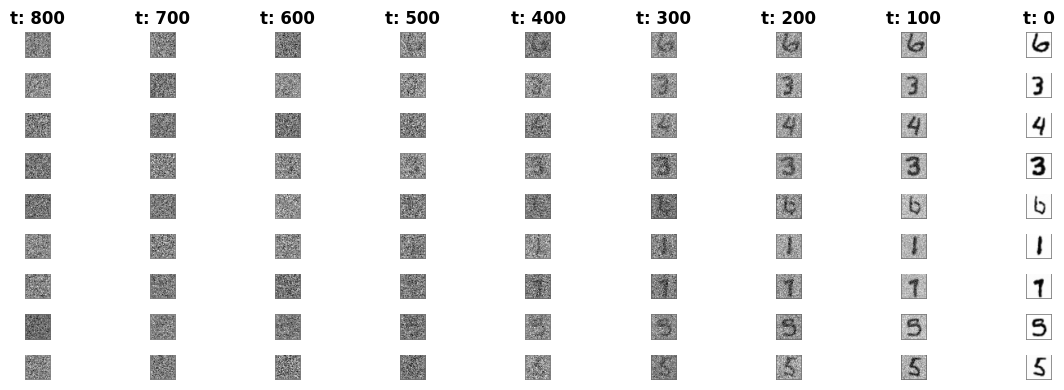

In [ ]:
step = [801, 701, 601,501, 401, 301, 201, 101, 1]

fig, axis = plt.subplots(nrows=n, ncols=len(step), figsize=(12, 4))
collect = collect[::-1]
collect = collect[0:len(step)]
collect = collect[::-1]

for r in range(n):
  for c in range(len(step)):
    img = collect[c][r].detach().cpu().permute(1, 2, 0)

    img[:,0,0] = 0
    img[0,:,0] = 0
    img[:,31,0]= 0
    img[31,:,0]= 0


    axis[r,c].imshow(255-img, cmap='gray')
    if(r==0):
      axis[r,c].set_title(f't: {step[c]-1}', fontweight='bold')
    axis[r,c].axis(False)

plt.tight_layout()
plt.savefig('unconditional_ddpm.png', dpi=300)

#### **Gaussian**

1000it [00:23, 42.12it/s]


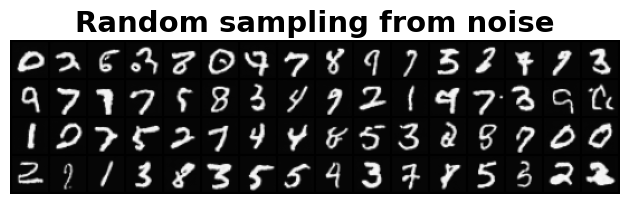

In [ ]:
sampled_imgs, _ = ddpm.ddpm_sampling(model=model, num_samples=64, channels=1, img_size=32)
grid = make_grid(sampled_imgs.detach().cpu(), nrow=16, normalize=True)
plt.figure(figsize=(12, 2))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis(False)
plt.title('Random sampling from noise', fontsize=21, fontweight='bold');

#### **Student_t**

1000it [00:23, 41.82it/s]


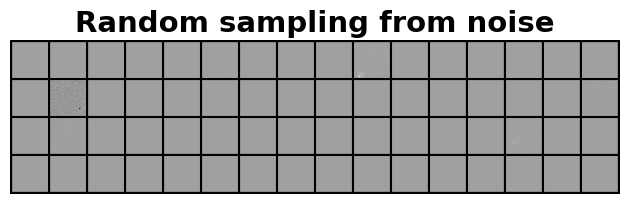

In [ ]:
sampled_imgs, _ = ddpm.ddpm_sampling_student_t(model=model, num_samples=64, channels=1, img_size=32)
grid = make_grid(sampled_imgs.detach().cpu(), nrow=16, normalize=True)
plt.figure(figsize=(12, 2))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis(False)
plt.title('Random sampling from noise', fontsize=21, fontweight='bold');

#### **Gamma**

1000it [00:23, 42.03it/s]


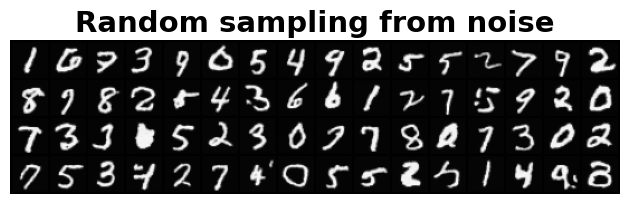

In [ ]:
sampled_imgs, _ = ddpm.ddpm_sampling_gamma_distribution(model=model, num_samples=64, channels=1, img_size=32)
grid = make_grid(sampled_imgs.detach().cpu(), nrow=16, normalize=True)
plt.figure(figsize=(12, 2))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis(False)
plt.title('Random sampling from noise', fontsize=21, fontweight='bold');

#### **Frechet**

1000it [00:21, 46.15it/s]


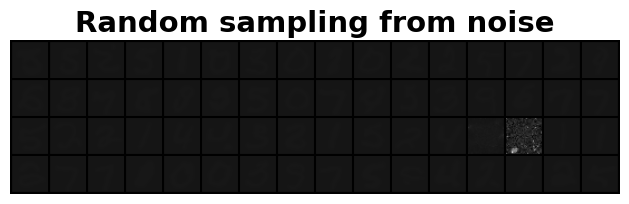

In [ ]:
sampled_imgs, _ = ddpm.ddpm_sampling_frechet(model=model, num_samples=64, channels=1, img_size=32)
grid = make_grid(sampled_imgs.detach().cpu(), nrow=16, normalize=True)
plt.figure(figsize=(12, 2))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis(False)
plt.title('Random sampling from noise', fontsize=21, fontweight='bold');